In [2]:
# CONTENTS

# load test data (messages & book)
# select (random) test sequence
# encode msg and book sequence for model

# get raw book data (L2) at the start of the sequence
# init simulator with initial book
# replay sequence in simulator (actual)

# load trained model
# predict next message
# map message to one the simulator understands & is valid
# apply message to simulator (predicted)
# get L2 representation and encode it for model

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
#os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".25"
import torch
torch.multiprocessing.set_start_method('spawn')

In [5]:
from argparse import Namespace
from glob import glob
import numpy as onp
import pandas as pd
from functools import partial
from typing import Union, Optional

import jax
import jax.numpy as jnp
from jax.nn import one_hot
from jax import random
from jax.scipy.linalg import block_diag
from flax.training import checkpoints
import orbax

#from lob.lob_seq_model import BatchLobPredModel
from lob.train_helpers import create_train_state, eval_step, prep_batch, cross_entropy_loss, compute_accuracy
from s5.ssm import init_S5SSM
from s5.ssm_init import make_DPLR_HiPPO
from s5.dataloading import make_data_loader
from lob_seq_model import LobPredModel
from encoding import Vocab, Message_Tokenizer
from lobster_dataloader import LOBSTER_Dataset, LOBSTER_Subset, LOBSTER_Sampler, LOBSTER

import preproc
import validation_helpers as valh
from lob.init_train import init_train_state, load_checkpoint, load_args_from_checkpoint

In [6]:
data_dir = '/nfs/home/peern/LOBS5/data/raw/'
save_dir = '/nfs/home/peern/LOBS5/data/simple_book/'

In [7]:
message_files = sorted(glob(data_dir + '*message*.csv'))
book_files = sorted(glob(data_dir + '*orderbook*.csv'))

In [8]:
# load test data (last day)

m = pd.read_csv(
    message_files[-1],
    names=['time', 'event_type', 'order_id', 'size', 'price', 'direction'],
    index_col=False)

b = pd.read_csv(
    book_files[-1],
    index_col=False,
    header=None
)

# remove diallowed order types
m = m.loc[m.event_type.isin([1, 2, 3, 4])]
b = b.loc[m.index]

/nfs/home/peern/rlenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/nfs/home/peern/rlenv/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


In [70]:
ticker = message_files[-1].rsplit('/', 1)[-1].split('_')[0]
data_date = message_files[-1].rsplit('/', 1)[-1].split('_')[1]

## Encoding

In [9]:
# Book encoding
price_levels = 500  # how many ticks to represent

In [10]:
# Message encoding
v = Vocab()
tok = Message_Tokenizer()

In [11]:
# encode from raw data

# print('<< pre processing >>')
# m_proc = tok.preproc(m, b)
# print('<< encoding >>')
# m_enc = tok.encode(m_proc, v)

# instead load from file:
msg_enc_file = sorted(glob(save_dir + '*message*.npy'))[-1]
m_enc = onp.load(msg_enc_file)

In [12]:
# remove first message from raw data as well
m = m.iloc[1:]

In [13]:
m_enc

array([[    3,     3,     8, ...,     2,     2,     2],
       [    3,     3,     8, ...,     2,     2,     2],
       [    3,     3,     9, ...,     2,     2,     2],
       ...,
       [   26,   402,   997, ..., 12008, 11009, 12010],
       [   26,   402,   985, ..., 12008, 11012, 12010],
       [   26,   402,  1002, ...,     2,     2,     2]])

In [14]:
m.shape

(1829106, 6)

In [15]:
# m_proc.shape

In [16]:
m_enc.shape

(1829106, 20)

In [17]:
# encode from raw data:
# b_enc = preproc.process_book(b, price_levels=price_levels)

# instead load from file:
book_enc_file = sorted(glob(save_dir + '*book*.npy'))[-1]
b_enc = onp.load(book_enc_file)
# convert to sparse volume representation
b_enc = preproc.transform_L2_state(b_enc, price_levels, 100)

In [18]:
#b_enc_ = preproc.process_book(b, price_levels=price_levels)

In [19]:
b.shape

(1829107, 40)

In [20]:
b_enc.shape

(1829107, 501)

In [21]:
#b_enc_.shape

## Data Initialisation

In [22]:
n_messages = 500

In [104]:
# when to start the prediction
start_time_dt = pd.to_datetime('11:00')
# convert time into seconds after midnight
start_time = (start_time_dt - pd.to_datetime('00:00')).total_seconds()
# get seq end index
end_i = len(m.loc[m.time < start_time])

In [24]:
m_seq = m_enc[end_i - n_messages : end_i].reshape(-1)  # (n_messages [500] * levels [20], )
# book state: we already include the book state after the last message
# (different to training where we only have the book state before the first message
# and mask part of the last message)
# for message seq, we first need to append an empty message
b_seq = b_enc[end_i - n_messages + 1 : end_i + 1]      # (n_messages [500], price_levels + 1 [41])

## Simulator

In [25]:
os.path.abspath('')

'/nfs/home/peern/LOBS5/lob'

In [26]:
import os
import sys

# add git submodule to path to allow imports to work
submodule_name = 'AlphaTrade'
(parent_folder_path, current_dir) = os.path.split(os.path.abspath(''))
sys.path.append(os.path.join(parent_folder_path, submodule_name))

In [27]:
from gymnax_exchange.jaxob.jorderbook import OrderBook
import gymnax_exchange.jaxob.JaxOrderbook as job

In [28]:
# TODO: integrate this into simualtor: OrderBook

def init_msgs_from_l2(book: Union[pd.Series, onp.ndarray]) -> jnp.ndarray:
    orderbookLevels = len(book) // 4  # price/quantity for bid/ask
    data = jnp.array(book).reshape(int(orderbookLevels*2),2)
    newarr = jnp.zeros((int(orderbookLevels*2),8))
    initOB = newarr \
        .at[:,3].set(data[:,0]) \
        .at[:,2].set(data[:,1]) \
        .at[:,0].set(1) \
        .at[0:orderbookLevels*4:2,1].set(-1) \
        .at[1:orderbookLevels*4:2,1].set(1) \
        .at[:,4].set(0) \
        .at[:,5].set(job.INITID) \
        .at[:,6].set(34200) \
        .at[:,7].set(0).astype('int32')
    return initOB

def msgs_to_jnp(m_df: pd.DataFrame) -> jnp.ndarray:
    m_df = m_df.copy()
    cols = ['Time', 'Type', 'OrderID', 'Quantity', 'Price', 'Side']
    if m_df.shape[1] == 7:
        cols += ["TradeID"]
    m_df.columns = cols
    m_df['TradeID'] = 0  #  TODO: should be TraderID for multi-agent support
    col_order=['Type','Side','Quantity','Price','TradeID','OrderID','Time']
    m_df = m_df[col_order]
    m_df = m_df[(m_df['Type'] != 6) & (m_df['Type'] != 7) & (m_df['Type'] != 5)]
    time = m_df["Time"].astype('string').str.split('.',expand=True)
    m_df[["TimeWhole","TimeDec"]] = time.astype('int32')
    m_df = m_df.drop("Time", axis=1)
    mJNP = jnp.array(m_df)
    return mJNP

def reset_orderbook(
        b: OrderBook,
        l2_book: Optional[Union[pd.Series, onp.ndarray]] = None,
    ) -> None:
    b.orderbook_array = b.orderbook_array.at[:].set(-1)
    if l2_book is not None:
        msgs = init_msgs_from_l2(l2_book)
        b.process_orders_array(msgs)

In [29]:
sim = OrderBook(price_levels=10, orderQueueLen=20)
sim

In [30]:
# init simulator at the start of the sequence
reset_orderbook(sim, b.iloc[end_i - n_messages])

In [31]:
# replay sequence in simulator (actual)
# so that sim is at the same state as the model
replay = msgs_to_jnp(m.iloc[end_i - n_messages : end_i])
trades = sim.process_orders_array(replay)

In [32]:
sim.get_L2_state()

Array([988100,    182, 987900,    802, 988200,   1056, 987800,    782,
       988300,    706, 987700,    600, 988400,   1100, 987600,    500,
       988500,   1012, 987500,   1250, 988600,    468, 987400,    775,
       988700,   1615, 987300,    490, 988800,    431, 987200,     50,
       989000,     50, 987100,    750,     -1,      0, 987000,     50],      dtype=int32)

In [33]:
sim.get_order_by_id_and_price(276499738, 987800)

Array([       82,    987800,         0, 276499738,     39599, 324469366],      dtype=int32)

In [34]:
sim.get_volume_at_price(0, 988100)

Array(182, dtype=int32)

In [35]:
# sim.orderbook_array[0][0]

In [36]:
# side = 1  # buy order entered on bid side (executed against ask)
# order_dict = {
#     # format decimals to nanosecond precision
#     'timestamp': format(40000.1, '.9f'),
#     'type': 'limit',
#     'order_id': 100,
#     'quantity': 21,
#     'price': 988100,
#     'side': 'ask' if side == -1 else 'bid',  # TODO: should be 'buy' or 'sell'
#     'trade_id': 0  # should be trader_id in future
# }

In [37]:
# sim.process_order(order_dict)

In [38]:
# sim.orderbook_array[0][0]

In [39]:
# sim.get_volume_at_price(0, 988100)

## Model

In [40]:
# necessary for checkpoints to be loaded in jupyter notebook

import nest_asyncio
nest_asyncio.apply()

In [41]:
#ckpt_path = '../checkpoints/brisk-surf-147_yc8wpyi3/'
#ckpt_path = '../checkpoints/scarlet-voice-168_iqq80fnp/'
ckpt_path = '../checkpoints/ancient-dawn-506_ykmjf41l/'

In [42]:
args = load_args_from_checkpoint(ckpt_path)

In [43]:
args

Namespace(C_init='trunc_standard_normal', USE_WANDB=True, activation_fn='half_glu1', batchnorm=True, bidirectional=True, blocks=8, bn_momentum=0.95, book_depth=500, book_transform=True, bsz=160, clip_eigs=True, conj_sym=True, cosine_anneal=True, d_model=128, dataset='lobster-prediction', dir_name='./data', discretization='zoh', dt_global=False, dt_max=0.1, dt_min=0.001, early_stop_patience=1000, epochs=100, jax_seed=42, lr_factor=1.0, lr_min=0, lr_patience=1000000, masking='causal', mode='pool', msg_seq_len=500, n_book_post_layers=1, n_book_pre_layers=1, n_data_workers=4, n_layers=6, n_message_layers=2, num_devices=5, opt_config='BandCdecay', p_dropout=0.2, prenorm=True, reduce_factor=1.0, restore=None, restore_step=None, ssm_lr_base=0.0005, ssm_size_base=256, use_book_data=True, use_simple_book=False, wandb_entity='peer-nagy', wandb_project='LOBS5', warmup_end=1, weight_decay=0.05)

In [44]:
# scale down to single GPU, single sample inference
args.bsz = 1
args.num_devices = 1

In [45]:
v = Vocab()
n_classes = len(v)
seq_len = n_messages * Message_Tokenizer.MSG_LEN
book_dim = b_enc.shape[1]
book_seq_len = n_messages

In [46]:
# temporary: add args if they were hardcoded during training this model

# args.use_book_data = True
# args.n_message_layers = 2
# args.n_book_pre_layers = 1
# args.n_book_post_layers = 1

In [47]:
new_train_state, model_cls = init_train_state(
    args,
    n_classes=n_classes,
    seq_len=seq_len,
    book_dim=book_dim,
    book_seq_len=book_seq_len,
)

configuring optimization with B in AdamW setup
[*] Trainable Parameters: 6206776


In [48]:
# check this works to only load first GPU train state

In [49]:
ckpt = load_checkpoint(
    new_train_state,
    ckpt_path,
    args.__dict__)
state = ckpt['model']

In [50]:
state = state.replace(
    params=jax.tree_map(lambda x: x[0], state.params),
    batch_stats=jax.tree_map(lambda x: x[0], state.batch_stats),
)

In [51]:
model = model_cls(training=False, step_rescale=1.0)

In [52]:
# from flax.training.train_state import TrainState
# from flax.core.frozen_dict import unfreeze


# # only use first GPU params
# params = unfreeze(jax.tree_map(lambda x: x[0], state.params))
# # state = TrainState.create(
#     apply_fn=model.apply,
#     params=unfreeze(jax.tree_map(lambda x: x[0], state.params)),
#     tx=None
# )

In [53]:
# TODO from above:
# x load trained model
#   predict next message
#   map message to one the simulator understands & is valid
#   apply message to simulator (predicted)
#   get L2 representation and encode it for model

In [54]:
# append new HID message (and next LOB state if not already in seq)
# loop: predict next token until full message is generated
# map message to one the simulator understands & is valid
# feed message to simulator (predicted) --> next book state
# encode next book state for model and append to book sequence

In [31]:
test = m.iloc[end_i - n_messages + 1 : end_i].copy()

In [33]:
test.append(
    {
        'time': 39599.940000,
        'event_type': 4,
        'order_id': 9000000,
        'size': 444,
        'price': 988000,
        'direction': 1,
    },
    ignore_index=True
)

,time,event_type,order_id,size,price,direction
0,39599.035239,3.0,276450034.0,66.0,988500.0,-1.0
1,39599.035239,1.0,276467070.0,66.0,989300.0,-1.0
2,39599.037035,3.0,276463294.0,43.0,988300.0,1.0
3,39599.037239,3.0,276463734.0,11.0,988400.0,1.0
4,39599.037555,3.0,276462994.0,100.0,988300.0,1.0
...,...,...,...,...,...,...
495,39599.861258,1.0,276516074.0,100.0,988500.0,-1.0
496,39599.868718,1.0,276516254.0,25.0,988300.0,-1.0
497,39599.868738,1.0,276516258.0,25.0,988200.0,-1.0
498,39599.935657,3.0,276503626.0,100.0,988100.0,-1.0


In [55]:
vocab_len = len(v)
batchnorm = args.batchnorm
sample_top_n = 10
rng = jax.random.PRNGKey(42)
rng, rng_ = jax.random.split(rng)

### Model Validation (optional)

In [99]:
dataset_obj = LOBSTER(
    'lobster',
    data_dir='/nfs/home/peern/LOBS5/data/',
    mask_fn=LOBSTER_Dataset.causal_mask,
    use_book_data=True,
    msg_seq_len=500,
)
dataset_obj.setup()

In [100]:
test_loader = make_data_loader(
    dataset_obj.dataset_test,
    dataset_obj,
    seed=args.jax_seed,
    batch_size=args.bsz,
    drop_last=True,
    shuffle=False,
    num_workers=0
)

In [54]:
rng = jax.random.PRNGKey(42)
tok = Message_Tokenizer()

all_pred_toks = []
all_labels = []

losses = []
accuracy = []
ranks = []
valid_mass = []
valid_mass_n5 = []
valid_pred = []
losses_baseline = []

VALID_MATRIX = valh.syntax_validation_matrix()

for batch_idx, batch in enumerate(test_loader):
    
    # PREPARE BATCH
    inputs, labels, integration_timesteps = prep_batch(batch, seq_len, n_classes)
    # INFERENCE STEP
    loss, acc, pred = eval_step(
        inputs, labels, integration_timesteps, state, model, args.batchnorm)
    
    # STORE RESULTS
    pred_toks = pred.argmax(axis=-1)
    all_labels += labels.tolist()
    all_pred_toks += pred_toks.tolist()
    
    # STATS
    losses.append(cross_entropy_loss(pred, labels))
    accuracy.append(compute_accuracy(pred, labels))
    
    # where does the correct label rank in the predicted distribution?
    ranks.append(valh.pred_rank(pred, labels))
    # how much of the predicted distribution is valid?
    masked_fields = valh.get_masked_fields(batch[0])
    valid_mass.append(valh.valid_prediction_mass(pred, masked_fields))
    valid_mass_n5.append(valh.valid_prediction_mass(pred, masked_fields, top_n=5))

    # check if argmax prediction is valid token for masked fields
    valid_pred.append(valh.is_tok_valid(pred_toks, masked_fields, v))

    # benchmark: uniform prediction over syntactically valid tokens
    pos = valh.get_masked_idx(batch[0])[..., -1]
    baseline_distr = VALID_MATRIX[pos] / VALID_MATRIX[pos].sum(axis=-1, keepdims=True)
    losses_baseline.append(cross_entropy_loss(jnp.log(
            jnp.where(baseline_distr==0, 1e-10, baseline_distr)
        ), labels)
    )

all_labels = jnp.array(all_labels)
all_pred_toks = jnp.array(all_pred_toks)
losses = jnp.array(losses)
accuracy = jnp.array(accuracy)
ranks = jnp.array(ranks)
valid_mass = jnp.array(valid_mass)
valid_mass_n5 = jnp.array(valid_mass_n5)
valid_pred = jnp.array(valid_pred)
losses_baseline = jnp.array(losses_baseline)

In [56]:
print('mean loss', losses.mean())
print('mean accuracy', accuracy.mean())
print('mean rank', ranks.mean())
print('median rank', onp.median(ranks))
print('mean valid mass', valid_mass.mean())
print('mean valid mass (top 5)', valid_mass_n5.mean())
print('mean valid prediction', valid_pred.mean())
print('mean baseline loss (uniform over valid syntax)', losses_baseline.mean())

mean loss 1.3281474
mean accuracy 0.7439693
mean rank 60.605537
median rank 0.0
mean valid mass 0.9925552
mean valid mass (top 5) 0.9898091
mean valid prediction 0.98903507
mean baseline loss (uniform over valid syntax) 4.266829


In [57]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as onp
import pandas as pd


precision, recall, fscore, support = precision_recall_fscore_support(
    all_labels.astype(int),
    all_pred_toks,
    labels=range(len(v)),
    zero_division=0,
    average=None
)

'''
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
'''

"\nprint('precision: {}'.format(precision))\nprint('recall: {}'.format(recall))\nprint('fscore: {}'.format(fscore))\nprint('support: {}'.format(support))\n"

In [58]:
field_dec = onp.array([(field, dec) for tok, (field, dec) in sorted(v.DECODING_GLOBAL.items())])

scores_df = pd.DataFrame({
    'field': field_dec[:, 0],
    'decoded': field_dec[:, 1],
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support,
})
#scores_df

In [249]:
# forecasting fields right to left direction

scores_df.loc[scores_df.support > 0].groupby('field').agg(
    precision=('precision', 'mean'),
    recall=('recall', 'mean'),
    fscore=('fscore', 'mean'),
    support=('support', 'sum'),
)

,precision,recall,fscore,support
field,,,,
direction,0.756392,0.509702,0.607549,531
event_type,0.615834,0.597230,0.605116,520
generic,0.713011,0.996881,0.831383,962
price,0.401648,0.383298,0.377822,553
size,0.122625,0.066499,0.078992,536
time,0.050324,0.061767,0.052441,546


In [59]:
# left to right causal prediction: e.g. direction already has price

scores_df.loc[scores_df.support > 0].groupby('field').agg(
    precision=('precision', 'mean'),
    recall=('recall', 'mean'),
    fscore=('fscore', 'mean'),
    support=('support', 'sum'),
)

,precision,recall,fscore,support
field,,,,
direction,0.928238,0.973527,0.950179,531
event_type,0.480274,0.500000,0.489918,520
generic,0.975104,0.977131,0.976116,962
price,0.255112,0.255230,0.223026,553
size,0.040464,0.031997,0.033178,536
time,0.013517,0.054023,0.020885,546


### Forecasting

In [56]:
# backup initial data for reset (ONCE!)
m_seq_start = m_seq.copy()
b_seq_start = b_seq.copy()

In [57]:
from gym_exchange.environment.base_env.assets.orderflow import OrderIdGenerator

In [58]:
sim.get_L2_state()

Array([988100,    182, 987900,    802, 988200,   1056, 987800,    782,
       988300,    706, 987700,    600, 988400,   1100, 987600,    500,
       988500,   1012, 987500,   1250, 988600,    468, 987400,    775,
       988700,   1615, 987300,    490, 988800,    431, 987200,     50,
       989000,     50, 987100,    750,     -1,      0, 987000,     50],      dtype=int32)

In [51]:
from typing import Any, Dict, Tuple, List


tick_size = 100


def get_sim_msg(
    pred_msg_enc: onp.ndarray,
    m_seq: onp.ndarray,
    m_seq_raw: pd.DataFrame,
    sim: OrderBook,
    tok: Message_Tokenizer,
    v: Vocab,
    new_order_id: int,
    tick_size: int
) -> Tuple[Optional[Dict[str, Any]], Optional[onp.ndarray]]:

    # decoded predicted message
    pred_msg = tok.decode(pred_msg_enc, v).flatten()
    #print('decoded predicted message:', pred_msg)

    if onp.isnan(pred_msg).all():
        return None, None
    
    orig_part = pred_msg[: len(pred_msg) // 2]
    modif_part = pred_msg[len(pred_msg) // 2:]

    # new order: no modification values present (all NA)
    # should be new LIMIT ORDER (1) or EXECUTION (4)
    if onp.isnan(modif_part).all():
        order_dict, msg_corr = get_sim_msg_new(sim, orig_part, new_order_id, tick_size)

    # modification / deletion of existing order
    else:
        # error in msg: some modifier field is nan
        if onp.isnan(modif_part).any():
            return None, None

        mod_type = int(modif_part[1])
        # cancel / delete
        if mod_type in {2, 3}:
            order_dict, msg_corr = get_sim_msg_mod(
                pred_msg_enc,
                orig_part,
                modif_part,
                m_seq,
                m_seq_raw,
                sim,
                tok,
                v,
                tick_size)
            
        # modify
        elif mod_type == 4:
            order_dict, msg_corr = get_sim_msg_exec(
                pred_msg_enc,
                orig_part,
                modif_part,
                m_seq,
                m_seq_raw,
                new_order_id,
                sim,
                tok,
                v,
                tick_size)

        # Invalid type of modification
        else:
            return None, None

    return order_dict, msg_corr

def get_sim_msg_new(
        sim: OrderBook,
        orig_part: onp.ndarray,
        new_order_id: int,
        tick_size: int,
    ) -> Tuple[Optional[Dict[str, Any]], Optional[onp.ndarray]]:

        event_type = int(orig_part[1])
        quantity = int(orig_part[2])
        side = int(orig_part[4])

        if onp.isnan(orig_part).any():
            return None, None
        
        assert event_type == 1
        # new limit order
        # if event_type == 1:
        print('NEW LIMIT ORDER')
        rel_price = int(orig_part[3])
        # convert relative to absolute price
        price = sim.get_best_bid() + rel_price * tick_size
            
        # type 4: order execution
        # else:
        #     print('ORDER EXECUTION')
        #     # make sure execution happens at best bid/ask
        #     # adjust price and quantity (down) accordingly to guarantee execution at only one price level
        #     #price = sim.get_best_ask() if side == 0 else sim.get_best_bid()
        #     if side == 0:
        #         price = sim.get_best_ask()
        #         rel_price = (price - sim.get_best_bid()) // tick_size
        #     else:
        #         price = sim.get_best_bid()
        #         rel_price = 0
        #     available_qty = sim.get_volume_at_price(side, price)
        #     quantity = min(quantity, available_qty)

        # TODO: validate timestamp (should be in the future but not too far)
        order_dict = {
            'timestamp': str(orig_part[0] * 1e-9 + 9.5 * 3600),
            'type': 'limit',
            'order_id': new_order_id, 
            'quantity': quantity,
            'price': price,
            'side': 'ask' if side == 0 else 'bid',  # TODO: should be 'buy' or 'sell'?
            'trade_id': 0  # should be trader_id in future
        }

        msg_corr = onp.array([
            str(int(orig_part[0])).zfill(15),
            str(event_type),
            str(quantity).zfill(4), 
            ('+' if rel_price > 0 else '-') + str(onp.abs(rel_price)).zfill(2),
            str(side),
        ])
        # encode corrected message
        msg_corr = tok.encode_msg(msg_corr, v)
        nan_part = onp.array((Message_Tokenizer.MSG_LEN // 2) * [Vocab.NA_TOK])
        msg_corr = onp.concatenate([msg_corr, nan_part])

        return order_dict, msg_corr

def rel_to_abs_price(
        p_rel: int,
        sim: OrderBook,
        tick_size: int = 100,
    ) -> int:

    assert tick_size % 10 == 0
    round_to = int(-onp.log10(tick_size))
    p_ref = onp.round((sim.get_best_bid() + sim.get_best_ask()) / 2, round_to)
    return p_ref + p_rel * tick_size

def get_sim_msg_mod(
        pred_msg_enc: onp.ndarray,
        orig_part: onp.ndarray,
        modif_part: onp.ndarray,
        m_seq: onp.ndarray,
        m_seq_raw: pd.DataFrame,
        sim: OrderBook,
        tok: Message_Tokenizer,
        v: Vocab,
        tick_size: int
    ) -> Tuple[Optional[Dict[str, Any]], Optional[onp.ndarray]]:

    print('ORDER CANCEL / DELETE')

    # the actual price of the order to be modified
    # p_mod_raw = sim.get_best_bid() + int(modif_part[3]) * tick_size
    p_mod_raw = rel_to_abs_price(int(modif_part[3]), sim, tick_size)
    side = int(modif_part[4])
    removed_quantity = int(modif_part[2])
    event_type = int(modif_part[1])

    print('rel price', int(modif_part[3]))
    print('side', side)
    print('removed_quantity (raw)', removed_quantity)
    print('total liquidity at price', sim.get_volume_at_price(side, p_mod_raw))
    print('event_type:', event_type)

    # make sure execution happens only if price generated at best bid/ask
    if event_type == 4:
        best_price = sim.get_best_ask() if side == 0 else sim.get_best_bid()
        if p_mod_raw != best_price:
            print('EXECUTION AT WRONG PRICE')
            return None, None
    
    # orig order before sequence start (no ref given or part missing)
    if onp.isnan(orig_part).any():
        # if no init volume remains at price, discard current message
        if sim.get_init_volume_at_price(side, p_mod_raw) == 0:
            return None, None
        order_id = job.INITID
        orig_msg_found = onp.array((Message_Tokenizer.MSG_LEN // 2) * [Vocab.NA_TOK])
    
    # search for original order to get correct ID
    else:
        m_seq = m_seq.copy().reshape((-1, Message_Tokenizer.MSG_LEN))
        # original part is only needed to match to an order ID
        # find original msg index location in the sequence (if it exists)
        orig_enc = pred_msg_enc[: len(pred_msg_enc) // 2]

        mask = get_invalid_ref_mask(m_seq_raw, p_mod_raw)
        orig_i, n_fields_removed = valh.try_find_msg(orig_enc, m_seq, seq_mask=mask)
        #orig_i = valh.find_orig_msg(orig_enc, m_seq)
        
        # didn't find matching original message
        if orig_i is None:
            if sim.get_init_volume_at_price(side, p_mod_raw) == 0:
                return None, None
            order_id = job.INITID
            orig_msg_found = onp.array((Message_Tokenizer.MSG_LEN // 2) * [Vocab.NA_TOK])
        
        # found matching original message
        else:
            # get order ID from raw data for simulator
            order_id = int(m_seq_raw.iloc[orig_i].order_id)
            orig_msg_found = onp.array(m_seq[orig_i, : Message_Tokenizer.MSG_LEN // 2])

    # get remaining quantity in book for given order ID
    print('looking for order', order_id, 'at price', p_mod_raw)
    remaining_quantity = sim.get_order_by_id_and_price(order_id, p_mod_raw)[0]
    if order_id != job.INITID:
        assert sim.get_order_by_id(order_id)[0] == remaining_quantity
    print('remaining quantity', remaining_quantity)
    if remaining_quantity == -1:
        remaining_quantity = sim.get_init_volume_at_price(side, p_mod_raw)
        print('remaining init qu.', remaining_quantity)
        # if no init volume remains at price, discard current message
        if remaining_quantity == 0:
            return None, None
        order_id = job.INITID
        orig_msg_found = onp.array((Message_Tokenizer.MSG_LEN // 2) * [Vocab.NA_TOK])

    # removing more than remaining quantity --> scale down to remaining
    if removed_quantity >= remaining_quantity:
        removed_quantity = remaining_quantity
        # change partial cancel to full delete
        if event_type == 2:
            event_type = 3
    # change full delete to partial cancel
    elif event_type == 3:
        event_type = 2

    print(f'(event_type={event_type}) -{removed_quantity} from {remaining_quantity} '
          + f'@{p_mod_raw} --> {remaining_quantity-removed_quantity}')

    if event_type == 2:
        sim_type = 'cancel'
        sim_side = side
    elif event_type == 3:
        sim_type = 'delete'
        sim_side = side
    elif event_type == 4:
        sim_type = 'limit'
        # convert execution side to limit order side for simulator
        sim_side = 0 if side == 1 else 1
    
    order_dict = {
        # format decimals to nanosecond precision
        'timestamp': format(modif_part[0] * 1e-9 + 9.5 * 3600, '.9f'),
        'type': sim_type,
        'order_id': order_id, 
        'quantity': removed_quantity,
        'price': p_mod_raw,
        'side': 'ask' if sim_side == 0 else 'bid',  # TODO: should be 'buy' or 'sell'
        'trade_id': 0  # should be trader_id in future
    }
    rel_price = int(modif_part[3])
    #corr_msg = onp.empty((len(pred_msg),))
    #corr_msg[: len(pred_msg) // 2] = orig_msg_found
    msg_corr = onp.array([
        str(int(modif_part[0])).zfill(15),
        str(event_type),
        str(removed_quantity).zfill(4), 
        ('+' if rel_price > 0 else '-') + str(onp.abs(rel_price)).zfill(2),
        str(side),
    ])
    # encode corrected message
    msg_corr = tok.encode_msg(msg_corr, v)
    msg_corr = onp.concatenate([orig_msg_found, msg_corr])

    return order_dict, msg_corr

def get_sim_msg_exec(
        pred_msg_enc: onp.ndarray,
        orig_part: onp.ndarray,
        modif_part: onp.ndarray,
        m_seq: onp.ndarray,
        m_seq_raw: pd.DataFrame,
        new_order_id: int,
        sim: OrderBook,
        tok: Message_Tokenizer,
        v: Vocab,
        tick_size: int
    ) -> Tuple[Optional[Dict[str, Any]], Optional[onp.ndarray]]:

    print('ORDER EXECUTION')

    # the actual price of the order to be modified
    p_mod_raw = rel_to_abs_price(int(modif_part[3]), sim, tick_size)
    side = int(modif_part[4])
    removed_quantity = int(modif_part[2])
    event_type = int(modif_part[1])

    print('event_type:', event_type)
    assert event_type == 4

    # get order against which execution is happening
    passive_order = sim.orderbook_array[side, 0, 0]
    if p_mod_raw != passive_order[1]:
        print('EXECUTION AT WRONG PRICE')
        return None, None

    remaining_quantity = passive_order[0]
    print('remaining quantity', remaining_quantity)
    if remaining_quantity == -1:
        print('NOTHING TO EXECUTE AGAINST (empty side of book)')
        return None, None

    # removing more than remaining quantity --> scale down to remaining
    if removed_quantity >= remaining_quantity:
        removed_quantity = remaining_quantity

    print(f'(event_type={event_type}) -{removed_quantity} from {remaining_quantity} '
          + f'@{p_mod_raw} --> {remaining_quantity-removed_quantity}')
    
    order_dict = {
        # format decimals to nanosecond precision
        'timestamp': format(modif_part[0] * 1e-9 + 9.5 * 3600, '.9f'),
        'type': 'limit',
        'order_id': new_order_id, 
        'quantity': removed_quantity,
        'price': p_mod_raw,
        'side': 'ask' if side == 1 else 'bid',  # CAVE: other side as cancels
        'trade_id': 0  # should be trader_id in future
    }
    rel_price = int(modif_part[3])
    msg_corr = onp.array([
        str(int(modif_part[0])).zfill(15),
        str(event_type),
        str(removed_quantity).zfill(4), 
        ('+' if rel_price > 0 else '-') + str(onp.abs(rel_price)).zfill(2),
        str(side),
    ])

    # correct the order which is executed in the sequence
    order_id = passive_order[3]
    orig_i = onp.argwhere(m_seq_raw.order_id.values == order_id)
    # found correct order
    if len(orig_i) > 0:
        m_seq = m_seq.copy().reshape((-1, Message_Tokenizer.MSG_LEN))
        print('orig_i', orig_i)
        print('m_seq[orig_i]', m_seq[orig_i])
        orig_i = orig_i.flatten()[0]
        orig_msg_found = onp.array(m_seq[orig_i, : Message_Tokenizer.MSG_LEN // 2])
    # didn't find correct order (e.g. INITID)
    else:
        orig_msg_found = onp.array((Message_Tokenizer.MSG_LEN // 2) * [Vocab.NA_TOK])

    # encode corrected message
    msg_corr = tok.encode_msg(msg_corr, v)
    msg_corr = onp.concatenate([orig_msg_found, msg_corr])

    return order_dict, msg_corr

def get_invalid_ref_mask(
        m_seq_raw: pd.DataFrame,
        p_mod_raw: int,
    ):

    # filter sequence to prices matching the correct price level
    wrong_price_mask = (m_seq_raw.price != p_mod_raw).astype(bool).values
    # to filter to orders still in the book: get order IDs from sim
    ids = sim.get_order_ids()
    # cave: convert from jax to numpy for isin() to work
    ids = onp.array(ids[ids != -1])
    not_in_book_mask = ~(m_seq_raw.order_id.isin(ids)).astype(bool).values
    mask = wrong_price_mask | not_in_book_mask
    return mask

# DEPRECATED: use preproc.transform_L2_state(.) instead
# def encode_L2_state(
#         book: jax.Array, 
#         price_levels: int, 
#     ) -> jax.Array:
#     """ Converts L2 book state (from from jax OrderBook.get_L2_state())
#         to price_levels many volume series used as input to the model.
#         Converts vols to negative vols for ask side (sell orders)
#     """
#     book = book.reshape((-1,2))
#     #best_bid = book[1, 0]
#     # set ask vols to negative values
#     book = book.at[::2, 1].set(book[::2, 1] * -1)
#     mid_price = jnp.round((book[0, 0] + book[1, 0]) / 2, -2).astype(int)
#     book = book.at[:, 0].set((book[:, 0] - mid_price) // 100)
#     # change relative prices to indices
#     book = book.at[:, 0].set(book[:, 0] + price_levels // 2)
#     # set to out of bounds index, so that we can use -1 to indicate nan
#     # out of bounds will be ignored in setting value in jax
#     nan_mask = (book == -1)
#     book = book.at[nan_mask].set(-price_levels-1)

#     mybook = jnp.zeros(price_levels, dtype=onp.int32)
#     mybook = mybook.at[book[:, 0]].set(book[:, 1])
#     #print(mybook)
#     return mybook

In [52]:
# side, level, q, field
sim.orderbook_array[0,0,0]

Array([      100,    988100,         0, 276492538,     39599, 264867549],      dtype=int32)

In [53]:
sim.get_order_by_id_and_price(276511822, 988100)

Array([       82,    988100,         0, 276511822,     39599, 685781583],      dtype=int32)

In [54]:
sim.get_order_by_id(276511822)

Array([       82,    988100,         0, 276511822,     39599, 685781583],      dtype=int32)

In [59]:
import matplotlib.pyplot as plt

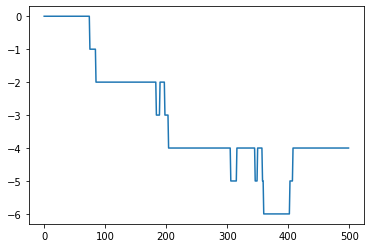

In [60]:
# price drift in sequence
plt.plot(onp.cumsum(b_seq[:, 0]))

In [ ]:
import inference

In [138]:
%matplotlib inline

sim.get_order_by_id(job.INITID)

Array([     293,   988600,        0, 90000000,    34200,        0], dtype=int32)

In [135]:
%matplotlib inline
sim.get_order_by_id_and_price(88001446, 987700)[0]

Array(100, dtype=int32)

ORDER CANCEL / DELETE
rel price 2
side 0
removed_quantity (raw) 100
total liquidity at price 1056
event_type: 3
no perfect match found
looking for order 276500518 at price 988200.0
remaining quantity 100
(event_type=3) -100 from 100 @988200.0 --> 0
{'timestamp': '39599.935653861', 'type': 'delete', 'order_id': 276500518, 'quantity': Array(100, dtype=int32), 'price': Array(988200., dtype=float32), 'side': 'ask', 'trade_id': 0}
len(m_seq_raw) 500
new raw msg time          39599.935653861
event_type                  3
order_id            276500518
size                      100
price                988200.0
direction                 ask
Name: 499, dtype: object
p_change 0

ORDER CANCEL / DELETE
rel price 2
side 0
removed_quantity (raw) 100
total liquidity at price 975
event_type: 3
no perfect match found
looking for order 276495642 at price 988200.0
remaining quantity 100
(event_type=3) -100 from 100 @988200.0 --> 0
{'timestamp': '39599.935683991', 'type': 'delete', 'order_id': 276495642, 

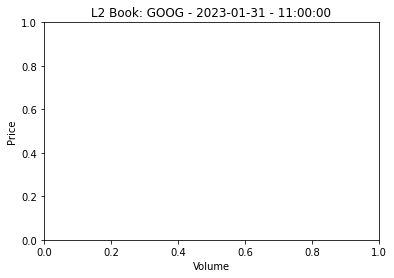

In [139]:
sim, _trades = inference.get_sim(
    b.iloc[end_i - n_messages],
    m.iloc[end_i - n_messages : end_i],
    sim_book_levels=10,
    sim_queue_len=20
)

m_seq, b_seq, m_seq_raw, l2_book_states = inference.generate(
    m_seq_start.copy(),
    b_seq_start.copy(),
    m.iloc[end_i - n_messages : end_i],
    500,
    sim,
    state,
    model,
    batchnorm,
    rng,
)

In [ ]:
# TODO: fix gif plotting -> axis labels, title, readable font (pillow? magick?)
#       run for longer, more messages --> check variation in mid price etc.
#       get started on D(t) encoding and model (branch)

In [107]:
def plot_l2_book(i_book, ax, xlim=None, ylim=None):
    i, book = i_book
    book = onp.array(book.reshape((-1, 2)))
    book[::2, 1] = book[::2, 1] * -1
    book = book[book[:, 0] != -1]

    ax.clear()
    plt.title("L2 Book: " + ticker + " - " + data_date + " - " + start_time_dt.strftime("%H:%M:%S"))
    plt.xlabel("Volume")
    plt.ylabel("Price")
    # option 2, remove all lines and collections
    # for artist in ax.lines + ax.collections:
    #     artist.remove()
    time_text = ax.text(
        0.05, 0.95, '#state: ' + str(i),
        horizontalalignment='left',verticalalignment='top',
        transform=ax.transAxes
    )
    
    bars = ax.barh(book[:, 0], book[:, 1], height=90, color='b')
    
    #xlim = ax.get_xlim()
    #x_abs_max = onp.max(onp.abs(xlim))
    #ax.set_xlim(-x_abs_max, x_abs_max)

    ylim = ax.get_ylim()
    p_mid = (book[0, 0] + book[1, 0]) / 2
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is None:
        y_half_range = onp.max((ylim[1] - p_mid, p_mid - ylim[0]))
        ax.set_ylim(p_mid + y_half_range, p_mid - y_half_range)
    else:
        ax.set_ylim(ylim)

    return bars

<BarContainer object of 19 artists>

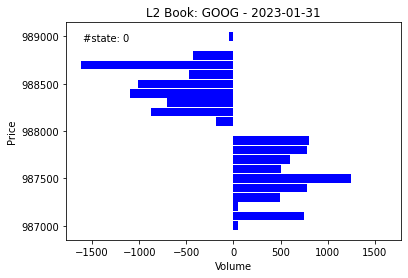

In [91]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
plt.title("L2 Book: " + ticker + " - " + data_date)
plt.xlabel("Volume")
plt.ylabel("Price")
max_vol = int(1.1 * onp.max(l2_book_states.reshape(l2_book_states.shape[0], -1, 2)[:, :, 1]))
xlim = (-max_vol, max_vol)

plot_l2_book((0, l2_book_states[1]), ax, xlim=xlim)

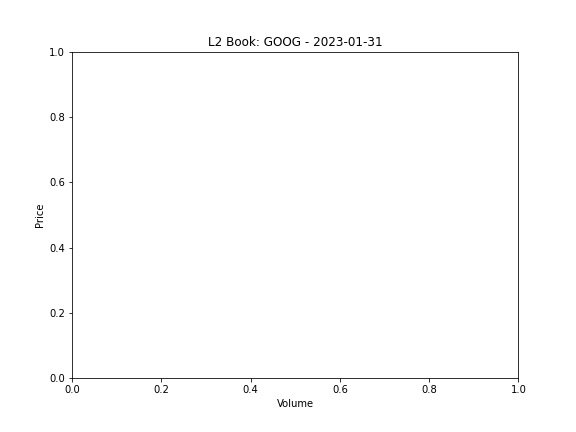

In [115]:
%matplotlib ipympl

import matplotlib.animation

max_vol = int(1.1 * onp.max(l2_book_states.reshape(l2_book_states.shape[0], -1, 2)[:, :, 1]))
xlim = (-max_vol, max_vol)

fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(111)
plt.title("L2 Book: " + ticker + " - " + data_date)
plt.xlabel("Volume")
plt.ylabel("Price")

ani = matplotlib.animation.FuncAnimation(
    fig,
    lambda b: plot_l2_book(b, ax, xlim=xlim),
    frames=list(enumerate(l2_book_states)),
    interval=200,
    repeat_delay=1000,
    #blit=True,
)
#plt.tight_layout()
plt.show()
ani.save(
    '../tmp/animation.webp',
    writer='imagemagick',
    fps=5,
    savefig_kwargs=dict(facecolor='#EAEAF2')
)

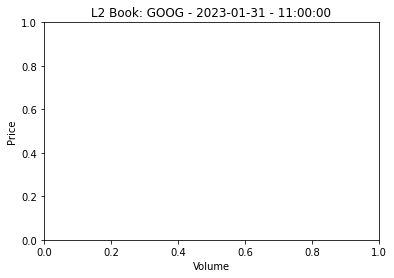

In [130]:
#pause
ani.event_source.stop()

#unpause
#ani.event_source.start()

In [66]:
tick_size = 100
sample_top_n = 50

# reset sequences
m_seq = m_seq_start.copy()
b_seq = b_seq_start.copy()

# reset simulator
sim = OrderBook(price_levels=10, orderQueueLen=20)
# init simulator at the start of the sequence
reset_orderbook(sim, b.iloc[end_i - n_messages])
# replay sequence in simulator (actual)
# so that sim is at the same state as the model
replay = msgs_to_jnp(m.iloc[end_i - n_messages : end_i])
trades = sim.process_orders_array(replay)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

id_gen = OrderIdGenerator()
valid_mask_array = valh.syntax_validation_matrix(v)
l = Message_Tokenizer.MSG_LEN

#for _ in range(100): #100
msg_todo = 100
while msg_todo > 0:
    rng, rng_ = jax.random.split(rng)

    #losses = []
    #accs = []
    m_seq = valh.append_hid_msg(m_seq)

    idx = range(l)
    # reversed_idx = [i \
    #    for field_i in reversed(list(range(len(Message_Tokenizer.FIELDS)))) \
    #    for i in range(*LOBSTER_Dataset._get_tok_slice_i(field_i))]

    for mask_i in idx:# reversed_idx:
        # syntactically valid tokens for current message position
        valid_mask = valid_mask_array[mask_i]

        m_seq, _ = valh.mask_last_msg_in_seq(m_seq, mask_i)
        #print(m_seq[-20:])
        # inference
        input = (
            one_hot(
                jnp.expand_dims(m_seq, axis=0), vocab_len
            ).astype(float),
            jnp.expand_dims(b_seq, axis=0)
        )
        integration_timesteps = (
            jnp.ones((1, len(m_seq))), 
            jnp.ones((1, len(b_seq)))
        )
        logits = valh.predict(
            input,
            integration_timesteps, state, model, batchnorm)
            #integration_timesteps, params, model, batchnorm)
        
        #print('1007', logits[0,1007], '1008', logits[0,1008], '1107', logits[0,1107])
        
        # filter out (syntactically) invalid tokens for current position
        #if valid_mask is not None:
        #    logits = valh.filter_valid_pred(logits, valid_mask)
        
        # TODO: remove - just for debugging
        #label = m_enc[end_i][mask_i]
        #losses.append(cross_entropy_loss(logits, label))
        #accs.append(compute_accuracy(logits, label))

        #print(m_seq[-20:])
        # update sequence
        # note: rng arg expects one element per batch element
        rng, rng_ = jax.random.split(rng)
        m_seq = valh.fill_predicted_toks(m_seq, logits, sample_top_n, jnp.array([rng_]))

    ### NEW:

    #m_seq_raw = m.iloc[end_i - n_messages : end_i]
    m_seq_raw = m.iloc[end_i - n_messages + 1 : end_i]
    order_id = id_gen.step()

    # parse generated message for simulator, also getting corrected raw message
    # (needs to be encoded and overwrite originally generated message)
    sim_msg, msg_corr = get_sim_msg(
        m_seq[-l:],
        m_seq[:-l],  # TODO: check if this should be the sequence without the generated msg
        m_seq_raw,
        sim,
        tok,
        v,
        new_order_id=order_id,
        tick_size=tick_size
    )

    if sim_msg is None:
        print('invalid message - discarding...')
        # cut away generated message and pad begginning of sequence
        m_seq = onp.concatenate([
            onp.full((l,), Vocab.NA_TOK),
            m_seq[: -l]])
        continue

    display(sim_msg)
    #print('quantitity', sim_msg['quantity'], 'price', sim_msg['price'])

    # replace in sequence
    #print('before', m_seq[-l:])
    #print('after', msg_corr)
    m_seq = m_seq.at[-l:].set(msg_corr)

    # feed message to simulator, updating book state
    p_mid_old = onp.round((sim.get_best_ask() + sim.get_best_bid()) / 2, -2).astype(int)
    #p_bid_old = sim.get_best_bid()
    _trades = sim.process_order(sim_msg)
    #p_bid_new = sim.get_best_bid()
    p_mid_new = onp.round((sim.get_best_ask() + sim.get_best_bid()) / 2, -2).astype(int)
    # p_change = (p_bid_new - p_bid_old) // tick_size
    p_change = (p_mid_new - p_mid_old) // tick_size

    # get new book state
    book = sim.get_L2_state()
    
    # new_book = encode_L2_state(book, price_levels=(b_seq.shape[1] - 1))
    # # prepend price jump to book state
    # new_book = jnp.concatenate([jnp.array([p_change]), new_book])
    # #print('new_book', new_book.shape, new_book)
    
    new_book_raw = jnp.concatenate([jnp.array([p_change]), book]).reshape(1,-1)
    new_book = preproc.transform_L2_state(new_book_raw, 500, 100)#[0]
    #print('new_book', new_book.shape, new_book)
    
    # update book sequence
    #b_seq = jnp.concatenate([b_seq[1:], jnp.expand_dims(new_book, axis=0)])
    b_seq = jnp.concatenate([b_seq[1:], new_book])

    print('p_change', p_change)
    print()

    msg_todo -= 1


NEW LIMIT ORDER


{'timestamp': '39599.935684982',
 'type': 'limit',
 'order_id': 88000221,
 'quantity': 100,
 'price': Array(987800, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.935669965',
 'type': 'limit',
 'order_id': 88000222,
 'quantity': 100,
 'price': Array(987800, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER EXECUTION
event_type: 4
remaining quantity 200
(event_type=4) -5 from 200 @987900.0 --> 195
orig_i [[414]]
m_seq[orig_i] [[[    8   402   327   446   553  1003  1057 12007 11010 12009     8
     402   355   501   703  1005  1057 12007 11008 12009]]]


{'timestamp': '39599.935657698',
 'type': 'limit',
 'order_id': 88000223,
 'quantity': 5,
 'price': Array(987900., dtype=float32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

ORDER EXECUTION
event_type: 4
EXECUTION AT WRONG PRICE
invalid message - discarding...
ORDER EXECUTION
event_type: 4
EXECUTION AT WRONG PRICE
invalid message - discarding...
ORDER EXECUTION
event_type: 4
remaining quantity 195
(event_type=4) -12 from 195 @987900.0 --> 183
orig_i [[414]]
m_seq[orig_i] [[[    8   402   355   502   192  1003  1107 12008 11008 12010     2
       2     2     2     2     2     2     2     2     2]]]


{'timestamp': '39599.927657704',
 'type': 'limit',
 'order_id': 88000226,
 'quantity': 12,
 'price': Array(987900., dtype=float32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.927684659',
 'type': 'limit',
 'order_id': 88000227,
 'quantity': 200,
 'price': Array(987900, dtype=int32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price 2
side 0
removed_quantity (raw) 100
total liquidity at price 1056
event_type: 3
matches: []
no perfect match found
looking for order 276489698 at price 988200.0
remaining quantity 100
(event_type=3) -100 from 100 @988200.0 --> 0


{'timestamp': '39599.927683698',
 'type': 'delete',
 'order_id': 276489698,
 'quantity': Array(100, dtype=int32),
 'price': Array(988200., dtype=float32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.92667866',
 'type': 'limit',
 'order_id': 88000229,
 'quantity': 100,
 'price': Array(987900, dtype=int32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price 3
side 0
removed_quantity (raw) 100
total liquidity at price 706
event_type: 3
matches: []
no perfect match found
looking for order 276489650 at price 988300.0
remaining quantity 81
(event_type=3) -81 from 81 @988300.0 --> 0


{'timestamp': '39599.927725790',
 'type': 'delete',
 'order_id': 276489650,
 'quantity': Array(81, dtype=int32),
 'price': Array(988300., dtype=float32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.927755661',
 'type': 'limit',
 'order_id': 88000231,
 'quantity': 100,
 'price': Array(987400, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -3
side 1
removed_quantity (raw) 100
total liquidity at price 600
event_type: 3
matches: []
no perfect match found
looking for order 90000000 at price 987700.0
remaining quantity 350
(event_type=2) -100 from 350 @987700.0 --> 250


{'timestamp': '39599.927771864',
 'type': 'cancel',
 'order_id': 90000000,
 'quantity': 100,
 'price': Array(987700., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.927765665',
 'type': 'limit',
 'order_id': 88000233,
 'quantity': 100,
 'price': Array(987400, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -7
side 1
removed_quantity (raw) 100
total liquidity at price 490
event_type: 3
matches: []
no perfect match found
looking for order 276488422 at price 987300.0
remaining quantity 50
(event_type=3) -50 from 50 @987300.0 --> 0


{'timestamp': '39599.927733662',
 'type': 'delete',
 'order_id': 276488422,
 'quantity': Array(50, dtype=int32),
 'price': Array(987300., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -7
side 1
removed_quantity (raw) 100
total liquidity at price 440
event_type: 3
matches: []
no perfect match found
looking for order 276500422 at price 987300.0
remaining quantity 22
(event_type=3) -22 from 22 @987300.0 --> 0


{'timestamp': '39599.927733684',
 'type': 'delete',
 'order_id': 276500422,
 'quantity': Array(22, dtype=int32),
 'price': Array(987300., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -7
side 1
removed_quantity (raw) 22
total liquidity at price 418
event_type: 3
matches: []
no perfect match found
looking for order 276503714 at price 987300.0
remaining quantity 306
(event_type=2) -22 from 306 @987300.0 --> 284


{'timestamp': '39599.927739582',
 'type': 'cancel',
 'order_id': 276503714,
 'quantity': 22,
 'price': Array(987300., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.927758671',
 'type': 'limit',
 'order_id': 88000237,
 'quantity': 100,
 'price': Array(987900, dtype=int32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price 1
side 0
removed_quantity (raw) 10
total liquidity at price 182
event_type: 3
matches: []
no perfect match found
invalid message - discarding...
NEW LIMIT ORDER


{'timestamp': '39596.927721651',
 'type': 'limit',
 'order_id': 88000239,
 'quantity': 100,
 'price': Array(987900, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.790760824',
 'type': 'limit',
 'order_id': 88000240,
 'quantity': 400,
 'price': Array(987700, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price 0
side 0
removed_quantity (raw) 100
total liquidity at price 0
event_type: 3
matches: []
no perfect match found
invalid message - discarding...
NEW LIMIT ORDER


{'timestamp': '39599.790735657996',
 'type': 'limit',
 'order_id': 88000242,
 'quantity': 62,
 'price': Array(987900, dtype=int32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price 2
side 0
removed_quantity (raw) 3
total liquidity at price 975
event_type: 3
matches: []
no perfect match found
looking for order 276489698 at price 988200.0
remaining quantity 100
(event_type=2) -3 from 100 @988200.0 --> 97


{'timestamp': '39599.790733659',
 'type': 'cancel',
 'order_id': 276489698,
 'quantity': 3,
 'price': Array(988200., dtype=float32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '38599.790692651004',
 'type': 'limit',
 'order_id': 88000244,
 'quantity': 50,
 'price': Array(987300, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.790702657',
 'type': 'limit',
 'order_id': 88000245,
 'quantity': 100,
 'price': Array(987400, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.792757656',
 'type': 'limit',
 'order_id': 88000246,
 'quantity': 100,
 'price': Array(987800, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.790696661',
 'type': 'limit',
 'order_id': 88000247,
 'quantity': 200,
 'price': Array(987700, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.790717659',
 'type': 'limit',
 'order_id': 88000248,
 'quantity': 100,
 'price': Array(987500, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -4
side 1
removed_quantity (raw) 100
total liquidity at price 500
event_type: 3
matches: []
no perfect match found
looking for order 90000000 at price 987600.0
remaining quantity 250
(event_type=2) -100 from 250 @987600.0 --> 150


{'timestamp': '39599.790717712',
 'type': 'cancel',
 'order_id': 90000000,
 'quantity': 100,
 'price': Array(987600., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39601.792670824',
 'type': 'limit',
 'order_id': 88000250,
 'quantity': 200,
 'price': Array(987400, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -2
side 1
removed_quantity (raw) 100
total liquidity at price 1082
event_type: 3
matches: []
no perfect match found
looking for order 276499746 at price 987800.0
remaining quantity 100
(event_type=3) -100 from 100 @987800.0 --> 0


{'timestamp': '39599.798705692',
 'type': 'delete',
 'order_id': 276499746,
 'quantity': Array(100, dtype=int32),
 'price': Array(987800., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.792760702',
 'type': 'limit',
 'order_id': 88000252,
 'quantity': 100,
 'price': Array(987500, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -4
side 1
removed_quantity (raw) 100
total liquidity at price 500
event_type: 3
matches: []
no perfect match found
looking for order 276503738 at price 987600.0
remaining quantity 200
(event_type=2) -100 from 200 @987600.0 --> 100


{'timestamp': '39599.792736760',
 'type': 'cancel',
 'order_id': 276503738,
 'quantity': 100,
 'price': Array(987600., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.927669725',
 'type': 'limit',
 'order_id': 88000254,
 'quantity': 50,
 'price': Array(988100, dtype=int32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.927672655',
 'type': 'limit',
 'order_id': 88000255,
 'quantity': 100,
 'price': Array(987200, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.805690654',
 'type': 'limit',
 'order_id': 88000256,
 'quantity': 50,
 'price': Array(987100, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.805698662',
 'type': 'limit',
 'order_id': 88000257,
 'quantity': 600,
 'price': Array(987000, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -9
side 1
removed_quantity (raw) 50
total liquidity at price 800
event_type: 3
matches: []
no perfect match found
looking for order 276515962 at price 987100.0
remaining quantity 600
(event_type=2) -50 from 600 @987100.0 --> 550


{'timestamp': '39599.808696656',
 'type': 'cancel',
 'order_id': 276515962,
 'quantity': 50,
 'price': Array(987100., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -1
side 1
removed_quantity (raw) 600
total liquidity at price 423
event_type: 3
matches: []
no perfect match found
looking for order 276503582 at price 987900.0
remaining quantity 65
(event_type=3) -65 from 65 @987900.0 --> 0


{'timestamp': '39599.805700668',
 'type': 'delete',
 'order_id': 276503582,
 'quantity': Array(65, dtype=int32),
 'price': Array(987900., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -1
side 1
removed_quantity (raw) 100
total liquidity at price 358
event_type: 3
matches: []
no perfect match found
looking for order 276515718 at price 987900.0
remaining quantity 100
(event_type=3) -100 from 100 @987900.0 --> 0


{'timestamp': '39599.805659719',
 'type': 'delete',
 'order_id': 276515718,
 'quantity': Array(100, dtype=int32),
 'price': Array(987900., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.805668665',
 'type': 'limit',
 'order_id': 88000261,
 'quantity': 100,
 'price': Array(987800, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -1
side 1
removed_quantity (raw) 52
total liquidity at price 258
event_type: 3
matches: []
no perfect match found
looking for order 276509918 at price 987900.0
remaining quantity 20
(event_type=3) -20 from 20 @987900.0 --> 0


{'timestamp': '39599.805669766',
 'type': 'delete',
 'order_id': 276509918,
 'quantity': Array(20, dtype=int32),
 'price': Array(987900., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -1
side 1
removed_quantity (raw) 100
total liquidity at price 238
event_type: 3
matches: []
no perfect match found
looking for order 276509918 at price 987900.0
remaining quantity 20
(event_type=3) -20 from 20 @987900.0 --> 0


{'timestamp': '39599.805690781',
 'type': 'delete',
 'order_id': 276509918,
 'quantity': Array(20, dtype=int32),
 'price': Array(987900., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.808660797',
 'type': 'limit',
 'order_id': 88000264,
 'quantity': 100,
 'price': Array(987700, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -1
side 1
removed_quantity (raw) 100
total liquidity at price 218
event_type: 3
matches: []
no perfect match found
looking for order 276515718 at price 987900.0
remaining quantity 100
(event_type=3) -100 from 100 @987900.0 --> 0


{'timestamp': '39599.806660765',
 'type': 'delete',
 'order_id': 276515718,
 'quantity': Array(100, dtype=int32),
 'price': Array(987900., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -3
side 1
removed_quantity (raw) 22
total liquidity at price 1300
event_type: 3
matches: []
no perfect match found
looking for order 276492482 at price 987700.0
remaining quantity 50
(event_type=2) -22 from 50 @987700.0 --> 28


{'timestamp': '39599.806660808',
 'type': 'cancel',
 'order_id': 276492482,
 'quantity': 22,
 'price': Array(987700., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.804712824',
 'type': 'limit',
 'order_id': 88000267,
 'quantity': 500,
 'price': Array(987700, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -3
side 1
removed_quantity (raw) 200
total liquidity at price 1778
event_type: 3
matches: []
no perfect match found
looking for order 276513250 at price 987700.0
remaining quantity 200
(event_type=3) -200 from 200 @987700.0 --> 0


{'timestamp': '39599.805739753',
 'type': 'delete',
 'order_id': 276513250,
 'quantity': Array(200, dtype=int32),
 'price': Array(987700., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '34599.805690818',
 'type': 'limit',
 'order_id': 88000269,
 'quantity': 600,
 'price': Array(987700, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.80171283',
 'type': 'limit',
 'order_id': 88000270,
 'quantity': 200,
 'price': Array(987400, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.80170083',
 'type': 'limit',
 'order_id': 88000271,
 'quantity': 100,
 'price': Array(987800, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price 1
side 0
removed_quantity (raw) 100
total liquidity at price 232
event_type: 3
matches: []
no perfect match found
looking for order 276492538 at price 988100.0
remaining quantity 100
(event_type=3) -100 from 100 @988100.0 --> 0


{'timestamp': '39599.801707996',
 'type': 'delete',
 'order_id': 276492538,
 'quantity': Array(100, dtype=int32),
 'price': Array(988100., dtype=float32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -10
side 1
removed_quantity (raw) 50
total liquidity at price 650
event_type: 3
matches: []
no perfect match found
looking for order 276497914 at price 987000.0
remaining quantity 50
(event_type=3) -50 from 50 @987000.0 --> 0


{'timestamp': '39599.801708299',
 'type': 'delete',
 'order_id': 276497914,
 'quantity': Array(50, dtype=int32),
 'price': Array(987000., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -3
side 1
removed_quantity (raw) 2
total liquidity at price 2178
event_type: 3
matches: []
no perfect match found
looking for order 276513250 at price 987700.0
remaining quantity 200
(event_type=2) -2 from 200 @987700.0 --> 198


{'timestamp': '39599.808708215',
 'type': 'cancel',
 'order_id': 276513250,
 'quantity': 2,
 'price': Array(987700., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.786708811',
 'type': 'limit',
 'order_id': 88000275,
 'quantity': 100,
 'price': Array(988100, dtype=int32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.800698817',
 'type': 'limit',
 'order_id': 88000276,
 'quantity': 100,
 'price': Array(987700, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -1
side 1
removed_quantity (raw) 311
total liquidity at price 158
event_type: 3
matches: []
no perfect match found
looking for order 276509918 at price 987900.0
remaining quantity 20
(event_type=3) -20 from 20 @987900.0 --> 0


{'timestamp': '39599.800698996',
 'type': 'delete',
 'order_id': 276509918,
 'quantity': Array(20, dtype=int32),
 'price': Array(987900., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.801698859',
 'type': 'limit',
 'order_id': 88000278,
 'quantity': 100,
 'price': Array(987900, dtype=int32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.80070382',
 'type': 'limit',
 'order_id': 88000279,
 'quantity': 100,
 'price': Array(987900, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.800703859',
 'type': 'limit',
 'order_id': 88000280,
 'quantity': 100,
 'price': Array(987900, dtype=int32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.800698815',
 'type': 'limit',
 'order_id': 88000281,
 'quantity': 100,
 'price': Array(987700, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -1
side 1
removed_quantity (raw) 100
total liquidity at price 38
event_type: 3
matches: []
no perfect match found
invalid message - discarding...
ORDER CANCEL / DELETE
rel price 0
side 0
removed_quantity (raw) 50
total liquidity at price 0
event_type: 3
matches: []
no perfect match found
invalid message - discarding...
ORDER CANCEL / DELETE
rel price -8
side 1
removed_quantity (raw) 200
total liquidity at price 150
event_type: 3
matches: []
no perfect match found
invalid message - discarding...
ORDER CANCEL / DELETE
rel price 0
side 1
removed_quantity (raw) 2
total liquidity at price 0
event_type: 3
matches: []
no perfect match found
invalid message - discarding...
NEW LIMIT ORDER


{'timestamp': '39599.800704793',
 'type': 'limit',
 'order_id': 88000286,
 'quantity': 100,
 'price': Array(987400, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -7
side 1
removed_quantity (raw) 100
total liquidity at price 446
event_type: 3
matches: []
no perfect match found
looking for order 276503714 at price 987300.0
remaining quantity 284
(event_type=2) -100 from 284 @987300.0 --> 184


{'timestamp': '39599.800982826',
 'type': 'cancel',
 'order_id': 276503714,
 'quantity': 100,
 'price': Array(987300., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -7
side 1
removed_quantity (raw) 100
total liquidity at price 346
event_type: 3
matches: []
no perfect match found
looking for order 276503714 at price 987300.0
remaining quantity 184
(event_type=2) -100 from 184 @987300.0 --> 84


{'timestamp': '39599.800763848',
 'type': 'cancel',
 'order_id': 276503714,
 'quantity': 100,
 'price': Array(987300., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -5
side 1
removed_quantity (raw) 100
total liquidity at price 1450
event_type: 3
matches: []
no perfect match found
looking for order 276507230 at price 987500.0
remaining quantity 100
(event_type=3) -100 from 100 @987500.0 --> 0


{'timestamp': '39599.800700815',
 'type': 'delete',
 'order_id': 276507230,
 'quantity': Array(100, dtype=int32),
 'price': Array(987500., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -8
side 1
removed_quantity (raw) 100
total liquidity at price 150
event_type: 3
matches: []
no perfect match found
looking for order 276489674 at price 987200.0
remaining quantity 50
(event_type=3) -50 from 50 @987200.0 --> 0


{'timestamp': '39599.800708848',
 'type': 'delete',
 'order_id': 276489674,
 'quantity': Array(50, dtype=int32),
 'price': Array(987200., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.798717743004',
 'type': 'limit',
 'order_id': 88000291,
 'quantity': 100,
 'price': Array(987100, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.786719859',
 'type': 'limit',
 'order_id': 88000292,
 'quantity': 100,
 'price': Array(987700, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.786719859',
 'type': 'limit',
 'order_id': 88000293,
 'quantity': 100,
 'price': Array(987700, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price 6
side 0
removed_quantity (raw) 100
total liquidity at price 468
event_type: 3
matches: []
no perfect match found
looking for order 276489778 at price 988600.0
remaining quantity 50
(event_type=3) -50 from 50 @988600.0 --> 0


{'timestamp': '39599.786666766',
 'type': 'delete',
 'order_id': 276489778,
 'quantity': Array(50, dtype=int32),
 'price': Array(988600., dtype=float32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.786689825996',
 'type': 'limit',
 'order_id': 88000295,
 'quantity': 100,
 'price': Array(987600, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -5
side 1
removed_quantity (raw) 100
total liquidity at price 1350
event_type: 3
matches: []
no perfect match found
looking for order 276507230 at price 987500.0
remaining quantity 100
(event_type=3) -100 from 100 @987500.0 --> 0


{'timestamp': '39599.786657765',
 'type': 'delete',
 'order_id': 276507230,
 'quantity': Array(100, dtype=int32),
 'price': Array(987500., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.786717725',
 'type': 'limit',
 'order_id': 88000297,
 'quantity': 100,
 'price': Array(987500, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.786655815',
 'type': 'limit',
 'order_id': 88000298,
 'quantity': 100,
 'price': Array(987600, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.786721876',
 'type': 'limit',
 'order_id': 88000299,
 'quantity': 100,
 'price': Array(987600, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -1
side 1
removed_quantity (raw) 100
total liquidity at price 38
event_type: 3
matches: []
no perfect match found
invalid message - discarding...
NEW LIMIT ORDER


{'timestamp': '39599.786722859004',
 'type': 'limit',
 'order_id': 88000301,
 'quantity': 100,
 'price': Array(987800, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.786760859',
 'type': 'limit',
 'order_id': 88000302,
 'quantity': 100,
 'price': Array(987700, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price 8
side 0
removed_quantity (raw) 100
total liquidity at price 431
event_type: 3
matches: []
no perfect match found
looking for order 276487218 at price 988800.0
remaining quantity 100
(event_type=3) -100 from 100 @988800.0 --> 0


{'timestamp': '39599.786757895',
 'type': 'delete',
 'order_id': 276487218,
 'quantity': Array(100, dtype=int32),
 'price': Array(988800., dtype=float32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price 1
side 0
removed_quantity (raw) 100
total liquidity at price 232
event_type: 3
matches: []
no perfect match found
invalid message - discarding...
NEW LIMIT ORDER


{'timestamp': '39599.805758895',
 'type': 'limit',
 'order_id': 88000305,
 'quantity': 100,
 'price': Array(987800, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.80575886',
 'type': 'limit',
 'order_id': 88000306,
 'quantity': 100,
 'price': Array(987700, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.806758859',
 'type': 'limit',
 'order_id': 88000307,
 'quantity': 3,
 'price': Array(988000, dtype=int32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.696722859',
 'type': 'limit',
 'order_id': 88000308,
 'quantity': 100,
 'price': Array(988000, dtype=int32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -5
side 1
removed_quantity (raw) 100
total liquidity at price 1350
event_type: 3
matches: []
no perfect match found
looking for order 276507230 at price 987500.0
remaining quantity 100
(event_type=3) -100 from 100 @987500.0 --> 0


{'timestamp': '39599.696761845',
 'type': 'delete',
 'order_id': 276507230,
 'quantity': Array(100, dtype=int32),
 'price': Array(987500., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -8
side 1
removed_quantity (raw) 50
total liquidity at price 100
event_type: 3
matches: []
no perfect match found
invalid message - discarding...
NEW LIMIT ORDER


{'timestamp': '39599.806758831',
 'type': 'limit',
 'order_id': 88000311,
 'quantity': 304,
 'price': Array(987000, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.806758858',
 'type': 'limit',
 'order_id': 88000312,
 'quantity': 100,
 'price': Array(987800, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -1
side 1
removed_quantity (raw) 200
total liquidity at price 38
event_type: 3
matches: []
no perfect match found
invalid message - discarding...
NEW LIMIT ORDER


{'timestamp': '39599.809769859',
 'type': 'limit',
 'order_id': 88000314,
 'quantity': 100,
 'price': Array(987800, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.80976886',
 'type': 'limit',
 'order_id': 88000315,
 'quantity': 100,
 'price': Array(987900, dtype=int32),
 'side': 'ask',
 'trade_id': 0}

p_change -2

NEW LIMIT ORDER


{'timestamp': '39599.809758858',
 'type': 'limit',
 'order_id': 88000316,
 'quantity': 100,
 'price': Array(987800, dtype=int32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39600.813763859',
 'type': 'limit',
 'order_id': 88000317,
 'quantity': 50,
 'price': Array(987600, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price 1
side 0
removed_quantity (raw) 2
total liquidity at price 62
event_type: 3
matches: []
no perfect match found
invalid message - discarding...
NEW LIMIT ORDER


{'timestamp': '39599.813763859',
 'type': 'limit',
 'order_id': 88000319,
 'quantity': 100,
 'price': Array(987700, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -3
side 1
removed_quantity (raw) 100
total liquidity at price 1250
event_type: 3
matches: []
no perfect match found
looking for order 276507230 at price 987500.0
remaining quantity 100
(event_type=3) -100 from 100 @987500.0 --> 0


{'timestamp': '39599.813769860',
 'type': 'delete',
 'order_id': 276507230,
 'quantity': Array(100, dtype=int32),
 'price': Array(987500., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.815763997',
 'type': 'limit',
 'order_id': 88000321,
 'quantity': 50,
 'price': Array(987600, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.815758766',
 'type': 'limit',
 'order_id': 88000322,
 'quantity': 100,
 'price': Array(987400, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.815758859',
 'type': 'limit',
 'order_id': 88000323,
 'quantity': 100,
 'price': Array(987600, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -1
side 1
removed_quantity (raw) 400
total liquidity at price 2876
event_type: 3
matches: []
no perfect match found
looking for order 276513250 at price 987700.0
remaining quantity 200
(event_type=3) -200 from 200 @987700.0 --> 0


{'timestamp': '39599.815759996',
 'type': 'delete',
 'order_id': 276513250,
 'quantity': Array(200, dtype=int32),
 'price': Array(987700., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.815763859',
 'type': 'limit',
 'order_id': 88000325,
 'quantity': 200,
 'price': Array(987600, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.815768858',
 'type': 'limit',
 'order_id': 88000326,
 'quantity': 200,
 'price': Array(987600, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.81575886',
 'type': 'limit',
 'order_id': 88000327,
 'quantity': 66,
 'price': Array(986800, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -2
side 1
removed_quantity (raw) 100
total liquidity at price 1300
event_type: 3
matches: []
no perfect match found
looking for order 276503738 at price 987600.0
remaining quantity 200
(event_type=2) -100 from 200 @987600.0 --> 100


{'timestamp': '39599.815797913',
 'type': 'cancel',
 'order_id': 276503738,
 'quantity': 100,
 'price': Array(987600., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -8
side 1
removed_quantity (raw) 300
total liquidity at price 904
event_type: 3
matches: []
no perfect match found
invalid message - discarding...
NEW LIMIT ORDER


{'timestamp': '39599.815758845',
 'type': 'limit',
 'order_id': 88000330,
 'quantity': 300,
 'price': Array(987700, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.871758996',
 'type': 'limit',
 'order_id': 88000331,
 'quantity': 304,
 'price': Array(987700, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.871758862',
 'type': 'limit',
 'order_id': 88000332,
 'quantity': 100,
 'price': Array(987700, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.871760861',
 'type': 'limit',
 'order_id': 88000333,
 'quantity': 100,
 'price': Array(987700, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.870758861',
 'type': 'limit',
 'order_id': 88000334,
 'quantity': 100,
 'price': Array(987700, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0



,time,event_type,order_id,size,price,direction
0,39599.935653861,3,276500518,100,988200.0,ask
1,39599.935683991,3,276495642,100,988200.0,ask
2,39599.935735089,3,276495642,100,988200.0,ask
3,39599.935743174,3,276486186,100,988500.0,ask
4,39599.937776683,3,276491902,100,988200.0,ask
...,...,...,...,...,...,...
495,39599.346980275,2,276498870,51,988400.0,ask
496,39599.298788258,1,88001979,100,987700,bid
497,39599.297802714,3,88001833,50,987100.0,bid
498,39598.294794258,1,88001981,306,987000,bid


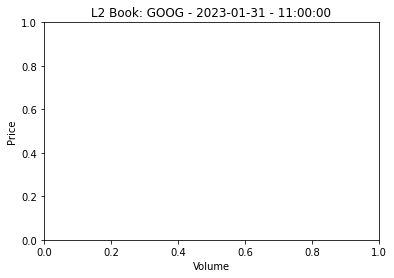

In [144]:
b_seq

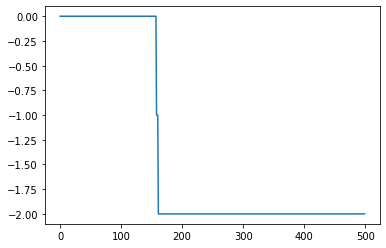

In [150]:
%matplotlib inline

# price drift in sequence
plt.plot(onp.cumsum(b_seq[:, 0]))

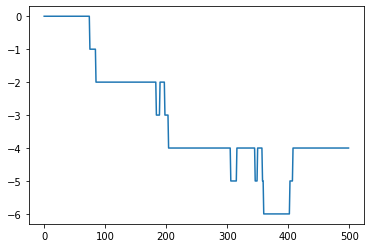

In [120]:
%matplotlib inline

# inspect movement of best bid price for sequence including
# generated flow at the end

# price drift in sequence
plt.plot(onp.cumsum(b_seq[:, 0]))

In [156]:
%matplotlib inline

l = Message_Tokenizer.MSG_LEN
decod_gen_msgs = tok.decode(m_seq.reshape((-1,l))[-100:], v)
decod_gen_msgs = pd.DataFrame(decod_gen_msgs, columns=Message_Tokenizer.FIELDS)
decod_gen_msgs

,time,event_type,size,price,direction,time_new,event_type_new,size_new,price_new,direction_new
0,5.399342e+12,1.0,100.0,-1.0,1.0,NaN,NaN,NaN,NaN,NaN
1,5.399282e+12,1.0,100.0,-2.0,1.0,5.399342e+12,3.0,100.0,-1.0,1.0
2,5.399350e+12,1.0,100.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
3,5.399282e+12,1.0,100.0,-2.0,1.0,5.399350e+12,3.0,100.0,-1.0,1.0
4,5.399257e+12,1.0,200.0,-1.0,1.0,5.399350e+12,2.0,100.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
95,5.399304e+12,1.0,600.0,4.0,0.0,5.399347e+12,2.0,51.0,6.0,0.0
96,5.399299e+12,1.0,100.0,-1.0,1.0,NaN,NaN,NaN,NaN,NaN
97,5.399334e+12,1.0,50.0,-7.0,1.0,5.399298e+12,3.0,50.0,-7.0,1.0
98,5.398295e+12,1.0,306.0,-8.0,1.0,NaN,NaN,NaN,NaN,NaN


In [160]:
%matplotlib inline
decod_gen_msgs['size'].value_counts().sort_index()

3.0       1
21.0      1
25.0      1
50.0     13
51.0     10
61.0      3
100.0    53
200.0    11
300.0     2
306.0     3
600.0     2
Name: size, dtype: int64

<AxesSubplot:>

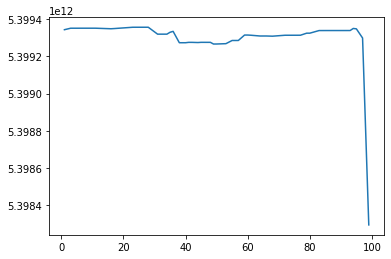

In [161]:
%matplotlib inline

# arriving mod times should be monotonically increasing...
decod_gen_msgs.dropna(subset=['time_new']).time_new.plot()

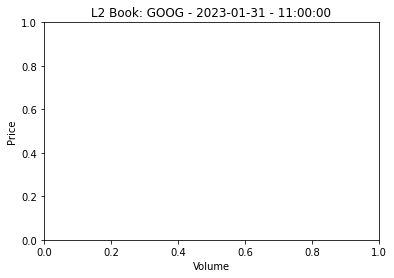

In [162]:
# new orders
new_orders = decod_gen_msgs.loc[decod_gen_msgs.time_new.isna()]

0     5.399342e+12
2     5.399350e+12
12    5.399350e+12
13    5.399346e+12
14    5.399346e+12
15    5.399348e+12
18    5.399372e+12
19    5.399354e+12
20    5.399355e+12
21    5.399355e+12
22    5.399355e+12
29    5.399313e+12
30    5.399317e+12
33    5.399318e+12
37    5.399256e+12
43    5.399273e+12
46    5.399271e+12
51    5.399265e+12
52    5.399265e+12
54    5.399256e+12
58    5.401286e+12
62    5.399311e+12
63    5.399308e+12
65    5.399309e+12
67    5.399309e+12
69    5.399308e+12
70    5.399312e+12
71    5.399312e+12
78    5.399324e+12
81    5.399338e+12
82    5.399338e+12
86    5.399338e+12
92    5.399338e+12
96    5.399299e+12
98    5.398295e+12
Name: time, dtype: float64

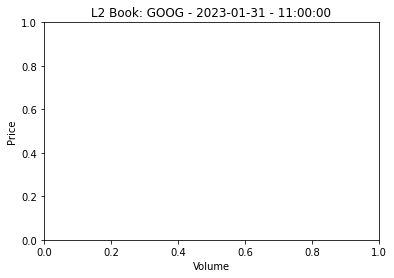

In [163]:
new_orders.time

<AxesSubplot:title={'center':'L2 Book: GOOG - 2023-01-31 - 11:00:00'}, xlabel='Volume', ylabel='Price'>

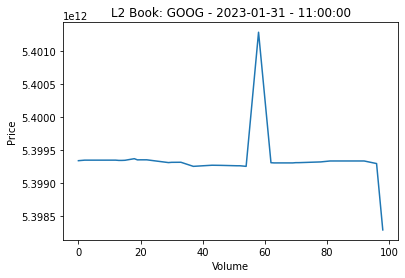

In [164]:
# error: should be monotonically increasing
new_orders.time.plot()

In [74]:
new_orders.event_type.value_counts()

1.0    65
Name: event_type, dtype: int64

In [75]:
# only order modifications
modif_orders = decod_gen_msgs.dropna()

In [76]:
modif_orders.event_type_new.value_counts()

3.0    22
2.0     9
4.0     2
Name: event_type_new, dtype: int64

## Scratch Work

In [70]:
# decode predicted message
pred_msg = tok.decode(m_seq[-20:], v).flatten()
pred_msg

array([5.00500501e+12, 1.00000000e+00, 1.00000000e+01, 1.00000000e+00,
       0.00000000e+00,            nan,            nan,            nan,
                  nan,            nan])

In [69]:
v.DECODING_GLOBAL[980]

('time', '977')

In [71]:
valh.validate_msg(m_seq[-20:], tok, v)

True

In [74]:
sim.orderbook_array.shape

(2, 10, 20, 6)

In [76]:
# side: 0: asks 1: bids
sim.get_volume_at_price(0, 988000)

Array(0, dtype=int32)

In [77]:
# side: 0: asks 1: bids
sim.get_volume_at_price(1, 987000)

Array(50, dtype=int32)

In [78]:
sim.get_volume_at_price(0, 988500)

Array(1012, dtype=int32)

In [79]:
from gym_exchange import Config
from gymnax_exchange.jaxob.JaxOrderbook import INITID

In [80]:
sim.get_init_volume_at_price(0, 988500)

Array(174, dtype=int32)

In [81]:
sim.get_L2_state()

Array([988100,    182, 987900,    802, 988200,   1056, 987800,    782,
       988300,    706, 987700,    600, 988400,   1100, 987600,    500,
       988500,   1012, 987500,   1250, 988600,    468, 987400,    775,
       988700,   1615, 987300,    490, 988800,    431, 987200,     50,
       989000,     50, 987100,    750,     -1,      0, 987000,     50],      dtype=int32)

In [ ]:
# TODO: add functions to jorderbook.py

In [ ]:
def msg_to_raw(msg, bid_price, tick_size):
    """Convert message to raw data format."""
    assert len(msg) == 5
    # time
    msg[0] = msg[0] * 1e-9 + 9.5 * 3600
    # price
    msg[3] = bid_price + int(msg[3]) * tick_size
    # direction
    msg[4] = msg[4] * 2 - 1
    return msg

In [ ]:
# actual next message (not predicted and not part of seq)
m_enc[end_i]

array([    8,   402,   328,   183,   770,  1003,  1207, 11107, 11011,
       11109,     8,   403,     9,   666,   752,  1005,  1107, 11107,
       11010, 11109])

In [ ]:
#raw_seq = m.iloc[end_i - n_messages: end_i].copy()
#raw_seq.drop('order_id', inplace=True, axis=1)

In [301]:
test_msg = m_enc[end_i].copy()
print('correct', test_msg)
#test_msg[2] -= 1  # modify time
#test_msg[6] += 1  # modify size
#test_msg[8] += 1  # modify price
print('modified', test_msg)

correct [    8   402   328   183   770  1003  1207 11107 11011 11109     8   403
     9   666   752  1005  1107 11107 11010 11109]
modified [    8   402   328   183   770  1003  1207 11107 11012 11109     8   403
     9   666   752  1005  1107 11107 11010 11109]


In [85]:
# use generated message
test_msg = m_seq[-20:].copy()

In [102]:
m_seq_raw = m.iloc[end_i - n_messages : end_i]

id_gen = OrderIdGenerator()
order_id = id_gen.step()

sim_msg, raw_vals = get_sim_msg(
    test_msg,
    m_seq,
    m_seq_raw,
    sim,
    tok,
    v,
    new_order_id=order_id,
    tick_size=100
)
sim_msg

raw_vals
['005005005005005', '1', '0010', '+01', '0']


{'timestamp': '39205.005005005',
 'type': 1,
 'order_id': 88000004,
 'quantity': 10,
 'price': Array(988000, dtype=int32),
 'side': 'ask',
 'trade_id': 0}

In [103]:
# TODO: do this for type 1, 4 messages as well

tok = Message_Tokenizer()
tok.encode_msg(raw_vals, v)

time 005005005005005
delim_i [3, 6, 9, 12]
1003
[8, 8, 8, 8, 8]

event_type 1
[1003]

size 0010
delim_i []
10003
[1017]

price +01
delim_i [1]
105
[11107, 11008]

direction 0
[11109]



array([    8,     8,     8,     8,     8,  1003,  1017, 11107, 11008,
       11109])

In [ ]:
sim.process_order(sim_msg)

[       5       -1       10   988200        0 32429970    39600  6663749]
[[[[      100    988000         0 276499246     39599 322500767]
   [       -1        -1        -1        -1        -1        -1]
   [       -1        -1        -1        -1        -1        -1]
   ...
   [       -1        -1        -1        -1        -1        -1]
   [       -1        -1        -1        -1        -1        -1]
   [       -1        -1        -1        -1        -1        -1]]

  [[      100    988100         0 276492538     39599 264867549]
   [       82    988100         0 276511822     39599 685781583]
   [       -1        -1        -1        -1        -1        -1]
   ...
   [       -1        -1        -1        -1        -1        -1]
   [       -1        -1        -1        -1        -1        -1]
   [       -1        -1        -1        -1        -1        -1]]

  [[       81    988200         0 276491886     39599  26281485]
   [      100    988200         0 276500518     39599  33606933

(Array([[-1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1]], dtype=int32),
 Array([       5,       -1,       10,   988200,        0, 32429970,
           39600,  6663749], dtype=int32))

In [ ]:
input[0].shape

(1, 10000, 11111)

In [ ]:
input[1].shape

(1, 500, 41)

In [ ]:
# TODO: refactor slightly and work in simulation step
#       and simulator matching orders

pred_n_messages = 1
valid_mask_array = valh.syntax_validation_matrix()
inf_seq = valh.pred_msg(
    start_seq,
    pred_n_messages,
    state,
    model,
    args.batchnorm,
    rng,
    valid_mask_array
)